In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from collection_library_utils import build_collection_library
import pickle
import torch
from data_parser import data_loader_full
import io
from matplotlib import cm
from utils import params
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else:
            return super().find_class(module, name)

file_path = 'Predicted/results.pkl'
with open(file_path, 'rb') as pickle_file:
    pred = CPU_Unpickler(pickle_file).load()

In [3]:
data_occupancy_all, data_flow_all, data_speed_all = data_loader_full()
X_occu_all, y_occu_all = data_occupancy_all[:, :2], data_occupancy_all[:, 2]
X_occu_all, y_occu_all = torch.tensor(X_occu_all, dtype=torch.float32, requires_grad=True), torch.tensor(y_occu_all, dtype=torch.float32).unsqueeze(1)

In [4]:
occu_recon = pred['occupancy_recon']
flow_recon = pred['flow_recon']
speed_recon = pred['speed_recon']

k_t = pred['k_t']
k_x = pred['k_x']
q_x = pred['q_x']
v_x = pred['v_x']

coeff = pred[('coefficients')]

### 3 mins prediction

In [5]:
z = torch.cat((occu_recon, flow_recon, speed_recon, k_x, q_x, v_x), dim=1)
Theta = build_collection_library(z, poly_order=params['poly_order'], include_sine=False, device= torch.device('cpu'))
k_t_predict = torch.matmul(Theta, coeff)

In [6]:
occu_1 = occu_recon + k_t_predict

In [7]:
pred_occu_recon = torch.cat((X_occu_all, occu_recon), dim=1).detach().numpy()
pred_occu_recon = pd.DataFrame(pred_occu_recon, columns = ['TimeStep','Station_Number','Occupancy'])
pred_occu_recon['TimeStep'] = pred_occu_recon['TimeStep'].astype(int)
pred_occu_recon['Station_Number'] = pred_occu_recon['Station_Number'].astype(int)
pred_occu_recon = pred_occu_recon.pivot(index='Station_Number', columns='TimeStep', values='Occupancy')

In [8]:
pred_occu_1 = torch.cat((X_occu_all, occu_1), dim=1).detach().numpy()
pred_occu_1 = pd.DataFrame(pred_occu_1, columns = ['TimeStep','Station_Number','Occupancy'])
pred_occu_1['TimeStep'] = pred_occu_1['TimeStep'].astype(int)
pred_occu_1['Station_Number'] = pred_occu_1['Station_Number'].astype(int)
pred_occu_1 = pred_occu_1.pivot(index='Station_Number', columns='TimeStep', values='Occupancy')
pred_occu_1.columns = pred_occu_1.columns + 1

In [9]:
# traffic flow prediction based on LWR Model
# The LWR model: dk/dt = -dq/dx, since we have k = 6*occu, thus d occu/dt = -(1/6)dq/dx
k_t_predict_LWR = -(1/6) * q_x
occu_1_LWR = occu_recon + k_t_predict_LWR

pred_occu_1_LWR = torch.cat((X_occu_all, occu_1_LWR), dim=1).detach().numpy()
pred_occu_1_LWR = pd.DataFrame(pred_occu_1_LWR, columns = ['TimeStep','Station_Number','Occupancy'])
pred_occu_1_LWR['TimeStep'] = pred_occu_1_LWR['TimeStep'].astype(int)
pred_occu_1_LWR['Station_Number'] = pred_occu_1_LWR['Station_Number'].astype(int)
pred_occu_1_LWR = pred_occu_1_LWR.pivot(index='Station_Number', columns='TimeStep', values='Occupancy')
pred_occu_1_LWR.columns = pred_occu_1_LWR.columns + 1

In [10]:
pred_flow_recon = torch.cat((X_occu_all, flow_recon), dim=1).detach().numpy()
pred_flow_recon = pd.DataFrame(pred_flow_recon, columns = ['TimeStep','Station_Number','Occupancy'])
pred_flow_recon['TimeStep'] = pred_flow_recon['TimeStep'].astype(int)
pred_flow_recon['Station_Number'] = pred_flow_recon['Station_Number'].astype(int)
pred_flow_recon = pred_flow_recon.pivot(index='Station_Number', columns='TimeStep', values='Occupancy')

In [11]:
# prediction based on the CTM model
pred_occu_1_CTM = pred_occu_recon.iloc[1:,:].values + 1/12 * pred_flow_recon.iloc[:-1,:].values - 1/12 * pred_flow_recon.iloc[1:,:].values
pred_occu_1_CTM = pd.DataFrame(pred_occu_1_CTM, index=pred_occu_recon.iloc[1:,:].index, columns=pred_occu_recon.iloc[1:,:].columns)
pred_occu_1_CTM.columns = pred_occu_1_CTM.columns + 1

In [12]:
from network import fullnetwork
from utils import params

In [13]:
# Load the checkpoint and load the checkpoint into the Network model
checkpoint = torch.load('Saved_Model/model_checkpoint.pt')
Network = fullnetwork(params).to(torch.device('cpu'))
Network.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [14]:
# convert pred_occu_1 to long format and input into Flow Net and Speed Net
pred_occu_1_long = pred_occu_1.transpose().stack().reset_index()
pred_occu_1_long.columns = ['TimeStep', 'Station_Number', 'Occupancy']
pred_occu_1_long = torch.tensor(pred_occu_1_long.values) # change pred_occu_1_long to torch.tensor type
# input pred_occu_1 into the FlowNet and SpeedNet
flow_1 = Network.FlowNet(pred_occu_1_long.float())
speed_1 = Network.SpeedNet(pred_occu_1_long.float())

In [15]:
# change flow_1 and speed_1 into pandas long format
pred_flow_1_long = torch.cat((pred_occu_1_long.float()[:, :2], flow_1), dim=1)
pred_speed_1_long = torch.cat((pred_occu_1_long.float()[:, :2], speed_1), dim=1)
pred_flow_1_long = pd.DataFrame(pred_flow_1_long.detach().numpy())
pred_speed_1_long = pd.DataFrame(pred_speed_1_long.detach().numpy())
pred_flow_1_long.columns = ['TimeStep', 'Station_Number', 'Flow']
pred_speed_1_long.columns = ['TimeStep', 'Station_Number', 'Speed']
pred_flow_1_long['TimeStep'] = pred_flow_1_long['TimeStep'].astype(int)
pred_flow_1_long['Station_Number'] = pred_flow_1_long['Station_Number'].astype(int)
pred_speed_1_long['TimeStep'] = pred_speed_1_long['TimeStep'].astype(int)
pred_speed_1_long['Station_Number'] = pred_speed_1_long['Station_Number'].astype(int)

In [16]:
# convert these two to wide format
pred_flow_1 = pred_flow_1_long.pivot(index='Station_Number', columns='TimeStep', values='Flow')
pred_speed_1 = pred_speed_1_long.pivot(index='Station_Number', columns='TimeStep', values='Speed')
# use numpy gradiant to calculate the derivatives
# first order
pred_k_x_1 = pd.DataFrame(np.gradient(pred_occu_1.to_numpy(), axis=0), index=pred_occu_1.index, columns=pred_occu_1.columns)
pred_q_x_1 = pd.DataFrame(np.gradient(pred_flow_1.to_numpy(), axis=0), index=pred_flow_1.index, columns=pred_flow_1.columns)
pred_v_x_1 = pd.DataFrame(np.gradient(pred_speed_1.to_numpy(), axis=0), index=pred_speed_1.index, columns=pred_speed_1.columns)

# second order
pred_k_xx_1 = pd.DataFrame(np.gradient(pred_k_x_1.to_numpy(), axis=0), index=pred_k_x_1.index, columns=pred_k_x_1.columns)
pred_q_xx_1 = pd.DataFrame(np.gradient(pred_q_x_1.to_numpy(), axis=0), index=pred_q_x_1.index, columns=pred_q_x_1.columns)
pred_v_xx_1 = pd.DataFrame(np.gradient(pred_v_x_1.to_numpy(), axis=0), index=pred_v_x_1.index, columns=pred_v_x_1.columns)

In [17]:
# convet pred_occu_1_LWR to long format and input into Flow Net and Speed Net
pred_occu_1_LWR_long = pred_occu_1_LWR.transpose().stack().reset_index()
pred_occu_1_LWR_long.columns = ['TimeStep', 'Station_Number', 'Occupancy']
pred_occu_1_LWR_long = torch.tensor(pred_occu_1_LWR_long.values)
flow_1_LWR = Network.FlowNet(pred_occu_1_LWR_long.float())

# convet pred_occu_1_CTM to long format and input into Flow Net and Speed Net
pred_occu_1_CTM_long = pred_occu_1_CTM.transpose().stack().reset_index()
pred_occu_1_CTM_long.columns = ['TimeStep', 'Station_Number', 'Occupancy']
pred_occu_1_CTM_long = torch.tensor(pred_occu_1_CTM_long.values)
flow_1_CTM = Network.FlowNet(pred_occu_1_CTM_long.float())

In [18]:
# change flow_1_LWR into pandas long format
pred_flow_1_LWR_long = torch.cat((pred_occu_1_LWR_long.float()[:, :2], flow_1_LWR), dim=1)
pred_flow_1_LWR_long = pd.DataFrame(pred_flow_1_LWR_long.detach().numpy())
pred_flow_1_LWR_long.columns = ['TimeStep', 'Station_Number', 'Flow']
pred_flow_1_LWR_long['TimeStep'] = pred_flow_1_LWR_long['TimeStep'].astype(int)
pred_flow_1_LWR_long['Station_Number'] = pred_flow_1_LWR_long['Station_Number'].astype(int)

pred_flow_1_LWR = pred_flow_1_LWR_long.pivot(index='Station_Number', columns='TimeStep', values='Flow')
pred_q_x_1_LWR = pd.DataFrame(np.gradient(pred_flow_1_LWR.to_numpy(), axis=0), index=pred_flow_1_LWR.index, columns=pred_flow_1_LWR.columns)

# change flow_1_CTM into pandas long format
pred_flow_1_CTM_long = torch.cat((pred_occu_1_CTM_long.float()[:, :2], flow_1_CTM), dim=1)
pred_flow_1_CTM_long = pd.DataFrame(pred_flow_1_CTM_long.detach().numpy())
pred_flow_1_CTM_long.columns = ['TimeStep', 'Station_Number', 'Flow']
pred_flow_1_CTM_long['TimeStep'] = pred_flow_1_CTM_long['TimeStep'].astype(int)
pred_flow_1_CTM_long['Station_Number'] = pred_flow_1_CTM_long['Station_Number'].astype(int)

pred_flow_1_CTM = pred_flow_1_CTM_long.pivot(index='Station_Number', columns='TimeStep', values='Flow')
pred_q_x_1_CTM = pd.DataFrame(np.gradient(pred_flow_1_CTM.to_numpy(), axis=0), index=pred_flow_1_CTM.index, columns=pred_flow_1_CTM.columns)


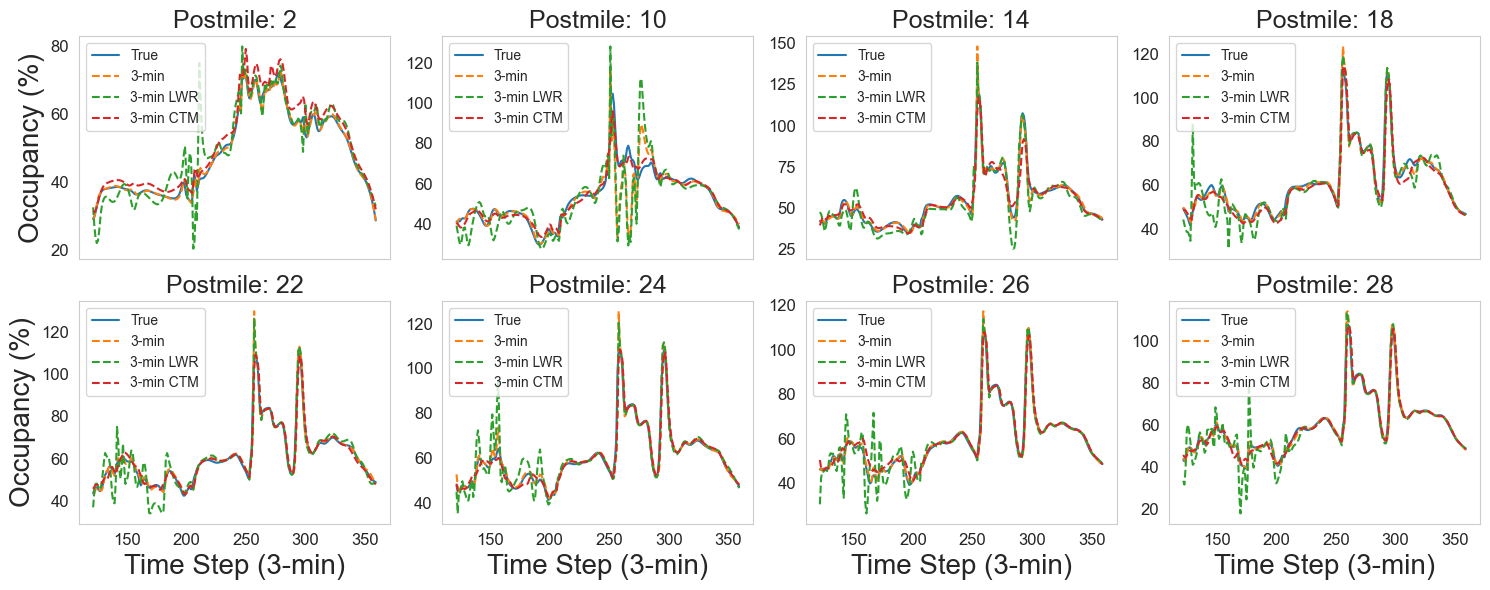

In [19]:
# plot 3-min traffic flow prediction
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 6), sharex=True)
axes = axes.flatten()
# select the postmiles (total 8) we need to include in the plot
select_postmile = [1, 5, 7, 9, 11, 12, 13, 14]

for i in range(8):
    col = select_postmile[i]
    axes[i].plot(pred_flow_recon.loc[col,:].iloc[1:], label='True')
    axes[i].plot(pred_flow_1.loc[col,:].iloc[:-1], linestyle = '--', label='3-min')
    axes[i].plot(pred_flow_1_LWR.loc[col,:].iloc[:-1], linestyle = '--', label='3-min LWR')
    axes[i].plot(pred_flow_1_CTM.loc[col,:].iloc[:-1], linestyle = '--', label='3-min CTM')
    axes[i].set_title(f'Postmile: {col * 2}', fontsize = 18)
    # axes[i].set_ylim(-0.6, 0.8)
    
    axes[i].tick_params(axis='both', which='major', labelsize=12)
    axes[i].legend()
    
    if i >= 4:  # Subplots 12 to 15 correspond to the last row (index starts from 0)
        axes[i].set_xlabel('Time Step (3-min)', fontsize=20)

    # Add y-axis labels only for the subplots in the first column
    if i % 4 == 0:  # Subplots 0, 4, 8, 12 correspond to the first column
        axes[i].set_ylabel('Occupancy (%)', fontsize=20)
    axes[i].grid(False)
    
plt.tight_layout()
plt.rcParams['font.family'] = 'Times New Roman'

In [20]:
rmse_flow_1_proposed = np.sqrt(np.nanmean((pred_flow_recon.iloc[:,1:].values - pred_flow_1.iloc[:,:-1].values) ** 2))
print(rmse_flow_1_proposed)

mape_flow_1_proposed = np.nanmean(np.abs((pred_flow_recon.iloc[:,1:].values - pred_flow_1.iloc[:,:-1].values) / pred_flow_recon.iloc[:,1:].values)) * 100
print(mape_flow_1_proposed)

3.6574423
2.541029639542103


In [21]:
rmse_flow_1_LWR = np.sqrt(np.nanmean((pred_flow_recon.iloc[:,1:].values - pred_flow_1_LWR.iloc[:,:-1].values) ** 2))
print(rmse_flow_1_LWR)

mape_flow_1_LWR = np.nanmean(np.abs((pred_flow_recon.iloc[:,1:].values - pred_flow_1_LWR.iloc[:,:-1].values) / pred_flow_recon.iloc[:,1:].values)) * 100
print(mape_flow_1_LWR)

6.6653476
7.475462555885315


In [22]:
rmse_flow_1_CTM = np.sqrt(np.nanmean((pred_flow_recon.iloc[1:,1:].values - pred_flow_1_CTM.iloc[:,:-1].values) ** 2))
print(rmse_flow_1_CTM)

mape_flow_1_CTM = np.nanmean(np.abs((pred_flow_recon.iloc[1:,1:].values - pred_flow_1_CTM.iloc[:,:-1].values) / pred_flow_recon.iloc[1:,1:].values)) * 100
print(mape_flow_1_CTM)

2.724276
3.2388590276241302


### 6 mins preditction

In [23]:
k_x_1 = pred_k_x_1.transpose().stack().reset_index()
k_x_1 = torch.tensor(k_x_1.values)[:, 2].unsqueeze(1)

q_x_1 = pred_q_x_1.transpose().stack().reset_index()
q_x_1 = torch.tensor(q_x_1.values)[:, 2].unsqueeze(1)

v_x_1 = pred_v_x_1.transpose().stack().reset_index()
v_x_1 = torch.tensor(v_x_1.values)[:, 2].unsqueeze(1)

k_xx_1 = pred_k_xx_1.transpose().stack().reset_index()
k_xx_1 = torch.tensor(k_xx_1.values)[:, 2].unsqueeze(1)

q_xx_1 = pred_q_xx_1.transpose().stack().reset_index()
q_xx_1 = torch.tensor(q_xx_1.values)[:, 2].unsqueeze(1)

v_xx_1 = pred_v_xx_1.transpose().stack().reset_index()
v_xx_1 = torch.tensor(v_xx_1.values)[:, 2].unsqueeze(1)

In [24]:
q_x_1_LWR = pred_q_x_1_LWR.transpose().stack().reset_index()
q_x_1_LWR = torch.tensor(q_x_1_LWR.values)[:, 2].unsqueeze(1)

In [25]:
z_1 = torch.cat((occu_1, flow_1, speed_1, k_x_1, q_x_1, v_x_1), dim=1)
Theta_1 = build_collection_library(z_1, poly_order=params['poly_order'], include_sine=False, device= torch.device('cpu')).float()
k_t_predict_1 = torch.matmul(Theta_1, coeff)

In [26]:
occu_2 = occu_1 + k_t_predict_1 

In [27]:
pred_occu_2 = torch.cat((X_occu_all, occu_2), dim=1).detach().numpy()
pred_occu_2 = pd.DataFrame(pred_occu_2, columns = ['TimeStep','Station_Number','Occupancy'])
pred_occu_2['TimeStep'] = pred_occu_2['TimeStep'].astype(int)
pred_occu_2['Station_Number'] = pred_occu_2['Station_Number'].astype(int)
pred_occu_2 = pred_occu_2.pivot(index='Station_Number', columns='TimeStep', values='Occupancy')
pred_occu_2.columns = pred_occu_2.columns + 2

In [28]:
# prediction based on LWR Model
# The LWR model: dk/dt = -dq/dx, since we have k = 6*occu, thus d occu/dt = -(1/6)dq/dx

k_t_predict_1_LWR = -(1/6) * q_x_1_LWR
occu_2_LWR = occu_1_LWR + k_t_predict_1_LWR

pred_occu_2_LWR = torch.cat((X_occu_all, occu_2_LWR), dim=1).detach().numpy()
pred_occu_2_LWR = pd.DataFrame(pred_occu_2_LWR, columns = ['TimeStep','Station_Number','Occupancy'])
pred_occu_2_LWR['TimeStep'] = pred_occu_2_LWR['TimeStep'].astype(int)
pred_occu_2_LWR['Station_Number'] = pred_occu_2_LWR['Station_Number'].astype(int)
pred_occu_2_LWR = pred_occu_2_LWR.pivot(index='Station_Number', columns='TimeStep', values='Occupancy')
pred_occu_2_LWR.columns = pred_occu_2_LWR.columns + 2

In [29]:
# prediction based on the CTM model
pred_occu_2_CTM = pred_occu_1_CTM.iloc[1:,:].values + 1/12 * pred_flow_1_CTM.iloc[:-1,:].values - 1/12 * pred_flow_1_CTM.iloc[1:,:].values
pred_occu_2_CTM = pd.DataFrame(pred_occu_2_CTM, index=pred_occu_1_CTM.iloc[1:,:].index, columns=pred_occu_1_CTM.columns)
pred_occu_2_CTM.columns = pred_occu_2_CTM.columns + 1

In [30]:
# convert pred_occu_2 to long format and input into Flow Net and Speed Net
pred_occu_2_long = pred_occu_2.transpose().stack().reset_index()
pred_occu_2_long.columns = ['TimeStep', 'Station_Number', 'Occupancy']
# change pred_occu_2_long to torch.tensor type
pred_occu_2_long = torch.tensor(pred_occu_2_long.values)
# input pred_occu_2 into the FlowNet and SpeedNet
flow_2 = Network.FlowNet(pred_occu_2_long.float())
speed_2 = Network.SpeedNet(pred_occu_2_long.float())

In [31]:
# change flow_2 and speed_2 into pandas long format
pred_flow_2_long = torch.cat((pred_occu_2_long.float()[:, :2], flow_1), dim=1)
pred_speed_2_long = torch.cat((pred_occu_2_long.float()[:, :2], speed_1), dim=1)
pred_flow_2_long = pd.DataFrame(pred_flow_2_long.detach().numpy())
pred_speed_2_long = pd.DataFrame(pred_speed_2_long.detach().numpy())
pred_flow_2_long.columns = ['TimeStep', 'Station_Number', 'Flow']
pred_speed_2_long.columns = ['TimeStep', 'Station_Number', 'Speed']
pred_flow_2_long['TimeStep'] = pred_flow_2_long['TimeStep'].astype(int)
pred_flow_2_long['Station_Number'] = pred_flow_2_long['Station_Number'].astype(int)
pred_speed_2_long['TimeStep'] = pred_speed_2_long['TimeStep'].astype(int)
pred_speed_2_long['Station_Number'] = pred_speed_2_long['Station_Number'].astype(int)

In [32]:
# convert these two to wide format
pred_flow_2 = pred_flow_2_long.pivot(index='Station_Number', columns='TimeStep', values='Flow')
pred_speed_2 = pred_speed_2_long.pivot(index='Station_Number', columns='TimeStep', values='Speed')

# use numpy gradiant to calculate the derivatives
# first order
pred_k_x_2 = pd.DataFrame(np.gradient(pred_occu_2.to_numpy(), axis=0), index=pred_occu_2.index, columns=pred_occu_2.columns)
pred_q_x_2 = pd.DataFrame(np.gradient(pred_flow_2.to_numpy(), axis=0), index=pred_flow_2.index, columns=pred_flow_2.columns)
pred_v_x_2 = pd.DataFrame(np.gradient(pred_speed_2.to_numpy(), axis=0), index=pred_speed_2.index, columns=pred_speed_2.columns)

# second order
pred_k_xx_2 = pd.DataFrame(np.gradient(pred_k_x_2.to_numpy(), axis=0), index=pred_k_x_2.index, columns=pred_k_x_2.columns)
pred_q_xx_2 = pd.DataFrame(np.gradient(pred_q_x_2.to_numpy(), axis=0), index=pred_q_x_2.index, columns=pred_q_x_2.columns)
pred_v_xx_2 = pd.DataFrame(np.gradient(pred_v_x_2.to_numpy(), axis=0), index=pred_v_x_2.index, columns=pred_v_x_2.columns)

In [33]:
# convet pred_occu_2_LWR to long format and input into Flow Net and Speed Net
pred_occu_2_LWR_long = pred_occu_2_LWR.transpose().stack().reset_index()
pred_occu_2_LWR_long.columns = ['TimeStep', 'Station_Number', 'Occupancy']
pred_occu_2_LWR_long = torch.tensor(pred_occu_2_LWR_long.values)
flow_2_LWR = Network.FlowNet(pred_occu_2_LWR_long.float())

# convet pred_occu_2_CTM to long format and input into Flow Net and Speed Net
pred_occu_2_CTM_long = pred_occu_2_CTM.transpose().stack().reset_index()
pred_occu_2_CTM_long.columns = ['TimeStep', 'Station_Number', 'Occupancy']
pred_occu_2_CTM_long = torch.tensor(pred_occu_2_CTM_long.values)
flow_2_CTM = Network.FlowNet(pred_occu_2_CTM_long.float())

In [34]:
# change flow_2_LWR into pandas long format
pred_flow_2_LWR_long = torch.cat((pred_occu_2_LWR_long.float()[:, :2], flow_2_LWR), dim=1)
pred_flow_2_LWR_long = pd.DataFrame(pred_flow_2_LWR_long.detach().numpy())
pred_flow_2_LWR_long.columns = ['TimeStep', 'Station_Number', 'Flow']
pred_flow_2_LWR_long['TimeStep'] = pred_flow_2_LWR_long['TimeStep'].astype(int)
pred_flow_2_LWR_long['Station_Number'] = pred_flow_2_LWR_long['Station_Number'].astype(int)

pred_flow_2_LWR = pred_flow_2_LWR_long.pivot(index='Station_Number', columns='TimeStep', values='Flow')
pred_q_x_2_LWR = pd.DataFrame(np.gradient(pred_flow_2_LWR.to_numpy(), axis=0), index=pred_flow_2_LWR.index, columns=pred_flow_2_LWR.columns)

# change flow_2_CTM into pandas long format
pred_flow_2_CTM_long = torch.cat((pred_occu_2_CTM_long.float()[:, :2], flow_2_CTM), dim=1)
pred_flow_2_CTM_long = pd.DataFrame(pred_flow_2_CTM_long.detach().numpy())
pred_flow_2_CTM_long.columns = ['TimeStep', 'Station_Number', 'Flow']
pred_flow_2_CTM_long['TimeStep'] = pred_flow_2_CTM_long['TimeStep'].astype(int)
pred_flow_2_CTM_long['Station_Number'] = pred_flow_2_CTM_long['Station_Number'].astype(int)

pred_flow_2_CTM = pred_flow_2_CTM_long.pivot(index='Station_Number', columns='TimeStep', values='Flow')
pred_q_x_2_CTM = pd.DataFrame(np.gradient(pred_flow_2_CTM.to_numpy(), axis=0), index=pred_flow_2_CTM.index, columns=pred_flow_2_CTM.columns)

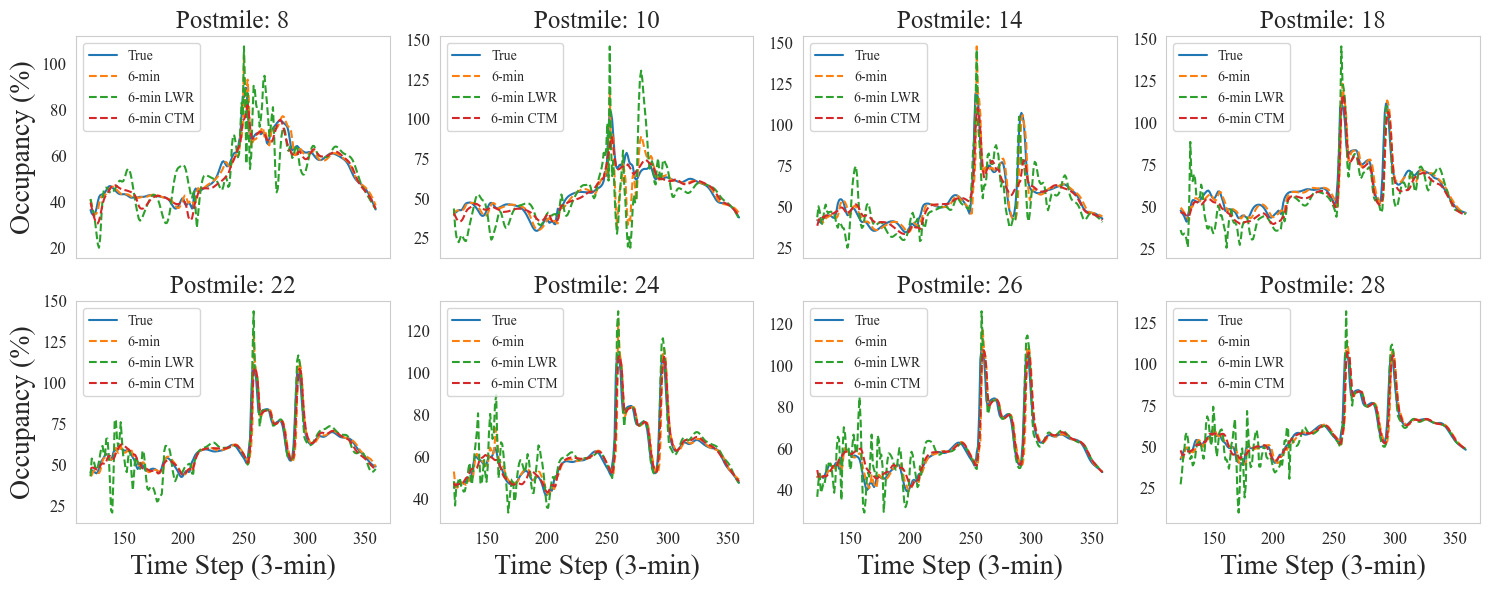

In [35]:
# plot 6-min traffic flow prediction
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 6), sharex=True)
axes = axes.flatten()
# select the postmiles (total 8) we need to include in the plot
select_postmile = [4, 5, 7, 9, 11, 12, 13, 14]

for i in range(8):
    col = select_postmile[i]
    axes[i].plot(pred_flow_recon.loc[col,:].iloc[2:], label='True')
    axes[i].plot(pred_flow_2.loc[col,:].iloc[:-2], linestyle = '--', label='6-min')
    axes[i].plot(pred_flow_2_LWR.loc[col,:].iloc[:-2], linestyle = '--', label='6-min LWR')
    axes[i].plot(pred_flow_2_CTM.loc[col,:].iloc[:-2], linestyle = '--', label='6-min CTM')
    axes[i].set_title(f'Postmile: {col * 2}', fontsize = 18)
    # axes[i].set_ylim(-0.6, 0.8)
    
    axes[i].tick_params(axis='both', which='major', labelsize=12)
    axes[i].legend()
    
    if i >= 4:  # Subplots 12 to 15 correspond to the last row (index starts from 0)
        axes[i].set_xlabel('Time Step (3-min)', fontsize=20)

    # Add y-axis labels only for the subplots in the first column
    if i % 4 == 0:  # Subplots 0, 4, 8, 12 correspond to the first column
        axes[i].set_ylabel('Occupancy (%)', fontsize=20)
    axes[i].grid(False)
    
plt.tight_layout()
plt.rcParams['font.family'] = 'Times New Roman'

In [36]:
rmse_flow_2_proposed = np.sqrt(np.nanmean((pred_flow_recon.iloc[:,2:].values - pred_flow_2.iloc[:,:-2].values) ** 2))
print(rmse_flow_2_proposed)

mape_flow_2_proposed = np.nanmean(np.abs((pred_flow_recon.iloc[:,2:].values - pred_flow_2.iloc[:,:-2].values) / pred_flow_recon.iloc[:,2:].values)) * 100
print(mape_flow_2_proposed)

5.1770296
4.030253365635872


In [37]:
rmse_flow_2_LWR = np.sqrt(np.nanmean((pred_flow_recon.iloc[:,2:].values - pred_flow_2_LWR.iloc[:,:-2].values) ** 2))
print(rmse_flow_2_LWR)

mape_flow_2_LWR = np.nanmean(np.abs((pred_flow_recon.iloc[:,2:].values - pred_flow_2_LWR.iloc[:,:-2].values) / pred_flow_recon.iloc[:,2:].values)) * 100
print(mape_flow_2_LWR)

10.336211
12.317967414855957


In [38]:
rmse_flow_2_CTM = np.sqrt(np.nanmean((pred_flow_recon.iloc[2:,2:].values - pred_flow_2_CTM.iloc[:,:-2].values) ** 2))
print(rmse_flow_2_CTM)

mape_flow_2_CTM = np.nanmean(np.abs((pred_flow_recon.iloc[2:,2:].values - pred_flow_2_CTM.iloc[:,:-2].values) / pred_flow_recon.iloc[2:,2:].values)) * 100
print(mape_flow_2_CTM)

4.388419
4.812127724289894


### 9 mins prediction

In [39]:
k_x_2 = pred_k_x_2.transpose().stack().reset_index()
k_x_2 = torch.tensor(k_x_2.values)[:, 2].unsqueeze(1)

q_x_2 = pred_q_x_2.transpose().stack().reset_index()
q_x_2 = torch.tensor(q_x_2.values)[:, 2].unsqueeze(1)

v_x_2 = pred_v_x_2.transpose().stack().reset_index()
v_x_2 = torch.tensor(v_x_2.values)[:, 2].unsqueeze(1)

k_xx_2 = pred_k_xx_2.transpose().stack().reset_index()
k_xx_2 = torch.tensor(k_xx_2.values)[:, 2].unsqueeze(1)

q_xx_2 = pred_q_xx_2.transpose().stack().reset_index()
q_xx_2 = torch.tensor(q_xx_2.values)[:, 2].unsqueeze(1)

v_xx_2 = pred_v_xx_2.transpose().stack().reset_index()
v_xx_2 = torch.tensor(v_xx_2.values)[:, 2].unsqueeze(1)

In [40]:
q_x_2_LWR = pred_q_x_2_LWR.transpose().stack().reset_index()
q_x_2_LWR = torch.tensor(q_x_2_LWR.values)[:, 2].unsqueeze(1)

In [41]:
z_2 = torch.cat((occu_2, flow_2, speed_2, k_x_2, q_x_2, v_x_2), dim=1)
Theta_2 = build_collection_library(z_2, poly_order=params['poly_order'], include_sine=False, device= torch.device('cpu')).float()
k_t_predict_2 = torch.matmul(Theta_2, coeff)

In [42]:
occu_3 = occu_2 + k_t_predict_2
pred_occu_3 = torch.cat((X_occu_all, occu_3), dim=1).detach().numpy()
pred_occu_3 = pd.DataFrame(pred_occu_3, columns=['TimeStep', 'Station_Number', 'Occupancy'])
pred_occu_3['TimeStep'] = pred_occu_3['TimeStep'].astype(int)
pred_occu_3['Station_Number'] = pred_occu_3['Station_Number'].astype(int)
pred_occu_3 = pred_occu_3.pivot(index='Station_Number', columns='TimeStep', values='Occupancy')
pred_occu_3.columns = pred_occu_3.columns + 3

In [43]:
# prediction based on LWR Model
# The LWR model: dk/dt = -dq/dx, since we have k = 6*occu, thus d occu/dt = -(1/6)dq/dx
k_t_predict_2_LWR = -(1/6) * q_x_2_LWR
occu_3_LWR = occu_2_LWR + k_t_predict_2_LWR

pred_occu_3_LWR = torch.cat((X_occu_all, occu_3_LWR), dim=1).detach().numpy()
pred_occu_3_LWR = pd.DataFrame(pred_occu_3_LWR, columns = ['TimeStep','Station_Number','Occupancy'])
pred_occu_3_LWR['TimeStep'] = pred_occu_3_LWR['TimeStep'].astype(int)
pred_occu_3_LWR['Station_Number'] = pred_occu_3_LWR['Station_Number'].astype(int)
pred_occu_3_LWR = pred_occu_3_LWR.pivot(index='Station_Number', columns='TimeStep', values='Occupancy')
pred_occu_3_LWR.columns = pred_occu_3_LWR.columns + 3

In [44]:
pred_occu_3_CTM = pred_occu_2_CTM.iloc[1:,:].values + 1/12 * pred_flow_2_CTM.iloc[:-1,:].values - 1/12 * pred_flow_2_CTM.iloc[1:,:].values
pred_occu_3_CTM = pd.DataFrame(pred_occu_3_CTM, index=pred_occu_2_CTM.iloc[1:,:].index, columns=pred_occu_2_CTM.columns)
pred_occu_3_CTM.columns = pred_occu_3_CTM.columns + 1

In [45]:
# convert pred_occu_3 to long format and input into Flow Net and Speed Net
pred_occu_3_long = pred_occu_3.transpose().stack().reset_index()
pred_occu_3_long.columns = ['TimeStep', 'Station_Number', 'Occupancy']
# change pred_occu_3_long to torch.tensor type
pred_occu_3_long = torch.tensor(pred_occu_3_long.values)
# input pred_occu_3 into the FlowNet and SpeedNet
flow_3 = Network.FlowNet(pred_occu_3_long.float())
speed_3 = Network.SpeedNet(pred_occu_3_long.float())
# change flow_3 and speed_3 into pandas long format
pred_flow_3_long = torch.cat((pred_occu_3_long.float()[:, :2], flow_1), dim=1)
pred_speed_3_long = torch.cat((pred_occu_3_long.float()[:, :2], speed_1), dim=1)
pred_flow_3_long = pd.DataFrame(pred_flow_3_long.detach().numpy())
pred_speed_3_long = pd.DataFrame(pred_speed_3_long.detach().numpy())
pred_flow_3_long.columns = ['TimeStep', 'Station_Number', 'Flow']
pred_speed_3_long.columns = ['TimeStep', 'Station_Number', 'Speed']
pred_flow_3_long['TimeStep'] = pred_flow_3_long['TimeStep'].astype(int)
pred_flow_3_long['Station_Number'] = pred_flow_3_long['Station_Number'].astype(int)
pred_speed_3_long['TimeStep'] = pred_speed_3_long['TimeStep'].astype(int)
pred_speed_3_long['Station_Number'] = pred_speed_3_long['Station_Number'].astype(int)
# convert these two to wide format
pred_flow_3 = pred_flow_3_long.pivot(index='Station_Number', columns='TimeStep', values='Flow')
pred_speed_3 = pred_speed_3_long.pivot(index='Station_Number', columns='TimeStep', values='Speed')

In [46]:
# convet pred_occu_3_LWR to long format and input into Flow Net and Speed Net
pred_occu_3_LWR_long = pred_occu_3_LWR.transpose().stack().reset_index()
pred_occu_3_LWR_long.columns = ['TimeStep', 'Station_Number', 'Occupancy']
pred_occu_3_LWR_long = torch.tensor(pred_occu_3_LWR_long.values)
flow_3_LWR = Network.FlowNet(pred_occu_3_LWR_long.float())

# convet pred_occu_3_CTM to long format and input into Flow Net and Speed Net
pred_occu_3_CTM_long = pred_occu_3_CTM.transpose().stack().reset_index()
pred_occu_3_CTM_long.columns = ['TimeStep', 'Station_Number', 'Occupancy']
pred_occu_3_CTM_long = torch.tensor(pred_occu_3_CTM_long.values)
flow_3_CTM = Network.FlowNet(pred_occu_3_CTM_long.float())

In [47]:
# change flow_3_LWR into pandas long format
pred_flow_3_LWR_long = torch.cat((pred_occu_3_LWR_long.float()[:, :2], flow_3_LWR), dim=1)
pred_flow_3_LWR_long = pd.DataFrame(pred_flow_3_LWR_long.detach().numpy())
pred_flow_3_LWR_long.columns = ['TimeStep', 'Station_Number', 'Flow']
pred_flow_3_LWR_long['TimeStep'] = pred_flow_3_LWR_long['TimeStep'].astype(int)
pred_flow_3_LWR_long['Station_Number'] = pred_flow_3_LWR_long['Station_Number'].astype(int)

pred_flow_3_LWR = pred_flow_3_LWR_long.pivot(index='Station_Number', columns='TimeStep', values='Flow')
pred_q_x_3_LWR = pd.DataFrame(np.gradient(pred_flow_3_LWR.to_numpy(), axis=0), index=pred_flow_3_LWR.index, columns=pred_flow_3_LWR.columns)

# change flow_3_CTM into pandas long format
pred_flow_3_CTM_long = torch.cat((pred_occu_3_CTM_long.float()[:, :2], flow_3_CTM), dim=1)
pred_flow_3_CTM_long = pd.DataFrame(pred_flow_3_CTM_long.detach().numpy())
pred_flow_3_CTM_long.columns = ['TimeStep', 'Station_Number', 'Flow']
pred_flow_3_CTM_long['TimeStep'] = pred_flow_3_CTM_long['TimeStep'].astype(int)
pred_flow_3_CTM_long['Station_Number'] = pred_flow_3_CTM_long['Station_Number'].astype(int)

pred_flow_3_CTM = pred_flow_3_CTM_long.pivot(index='Station_Number', columns='TimeStep', values='Flow')
pred_q_x_3_CTM = pd.DataFrame(np.gradient(pred_flow_3_CTM.to_numpy(), axis=0), index=pred_flow_3_CTM.index, columns=pred_flow_3_CTM.columns)

In [48]:
# use numpy gradiant to calculate the derivatives
# first order
pred_k_x_3 = pd.DataFrame(np.gradient(pred_occu_3.to_numpy(), axis=0), index=pred_occu_3.index,
                          columns=pred_occu_3.columns)
pred_q_x_3 = pd.DataFrame(np.gradient(pred_flow_3.to_numpy(), axis=0), index=pred_flow_3.index,
                          columns=pred_flow_3.columns)
pred_v_x_3 = pd.DataFrame(np.gradient(pred_speed_3.to_numpy(), axis=0), index=pred_speed_3.index,
                          columns=pred_speed_3.columns)

# second order
pred_k_xx_3 = pd.DataFrame(np.gradient(pred_k_x_3.to_numpy(), axis=0), index=pred_k_x_3.index,
                           columns=pred_k_x_3.columns)
pred_q_xx_3 = pd.DataFrame(np.gradient(pred_q_x_3.to_numpy(), axis=0), index=pred_q_x_3.index,
                           columns=pred_q_x_3.columns)
pred_v_xx_3 = pd.DataFrame(np.gradient(pred_v_x_3.to_numpy(), axis=0), index=pred_v_x_3.index,
                           columns=pred_v_x_3.columns)


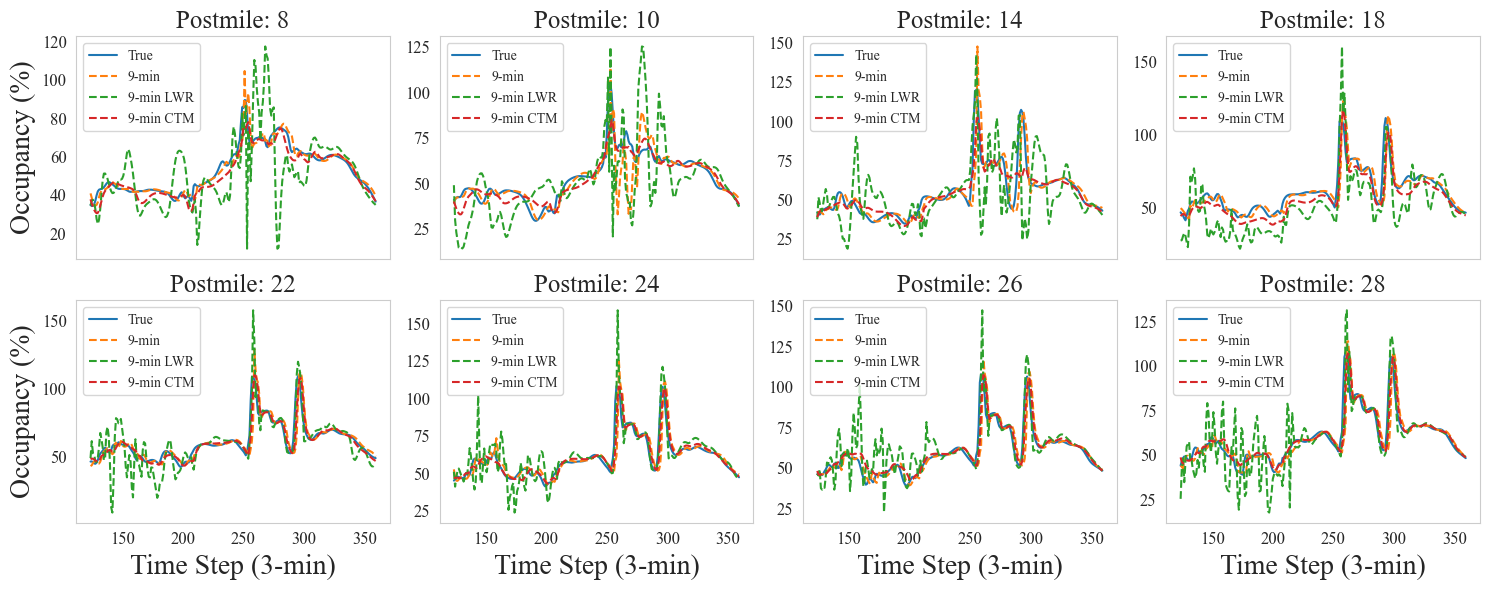

In [49]:
# plot 9-min traffic flow prediction
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 6), sharex=True)
axes = axes.flatten()
# select the postmiles (total 8) we need to include in the plot
select_postmile = [4, 5, 7, 9, 11, 12, 13, 14]

for i in range(8):
    col = select_postmile[i]
    axes[i].plot(pred_flow_recon.loc[col,:].iloc[3:], label='True')
    axes[i].plot(pred_flow_3.loc[col,:].iloc[:-3], linestyle = '--', label='9-min')
    axes[i].plot(pred_flow_3_LWR.loc[col,:].iloc[:-3], linestyle = '--', label='9-min LWR')
    axes[i].plot(pred_flow_3_CTM.loc[col,:].iloc[:-3], linestyle = '--', label='9-min CTM')
    axes[i].set_title(f'Postmile: {col * 2}', fontsize = 18)
    # axes[i].set_ylim(-0.6, 0.8)
    
    axes[i].tick_params(axis='both', which='major', labelsize=12)
    axes[i].legend()
    
    if i >= 4:  # Subplots 12 to 15 correspond to the last row (index starts from 0)
        axes[i].set_xlabel('Time Step (3-min)', fontsize=20)

    # Add y-axis labels only for the subplots in the first column
    if i % 4 == 0:  # Subplots 0, 4, 8, 12 correspond to the first column
        axes[i].set_ylabel('Occupancy (%)', fontsize=20)
    axes[i].grid(False)
    
plt.tight_layout()
plt.rcParams['font.family'] = 'Times New Roman'

In [50]:
rmse_flow_3_proposed = np.sqrt(np.nanmean((pred_flow_recon.iloc[:,3:].values - pred_flow_3.iloc[:,:-3].values) ** 2))
print(rmse_flow_3_proposed)

mape_flow_3_proposed = np.nanmean(np.abs((pred_flow_recon.iloc[:,3:].values - pred_flow_3.iloc[:,:-3].values) / pred_flow_recon.iloc[:,3:].values)) * 100
print(mape_flow_3_proposed)

7.0815153
5.630761757493019


In [51]:
rmse_flow_3_LWR = np.sqrt(np.nanmean((pred_flow_recon.iloc[:,3:].values - pred_flow_3_LWR.iloc[:,:-3].values) ** 2))
print(rmse_flow_3_LWR)

mape_flow_3_LWR = np.nanmean(np.abs((pred_flow_recon.iloc[:,3:].values - pred_flow_3_LWR.iloc[:,:-3].values) / pred_flow_recon.iloc[:,3:].values)) * 100
print(mape_flow_3_LWR)

16.194227
19.169768691062927


In [52]:
rmse_flow_3_CTM = np.sqrt(np.nanmean((pred_flow_recon.iloc[3:,3:].values - pred_flow_3_CTM.iloc[:,:-3].values) ** 2))
print(rmse_flow_3_CTM)

mape_flow_3_CTM = np.nanmean(np.abs((pred_flow_recon.iloc[3:,3:].values - pred_flow_3_CTM.iloc[:,:-3].values) / pred_flow_recon.iloc[3:,3:].values)) * 100
print(mape_flow_3_CTM)

5.8523426
6.024077534675598


### 12 mins prediction

In [53]:
k_x_3 = pred_k_x_3.transpose().stack().reset_index()
k_x_3 = torch.tensor(k_x_3.values)[:, 2].unsqueeze(1)

q_x_3 = pred_q_x_3.transpose().stack().reset_index()
q_x_3 = torch.tensor(q_x_3.values)[:, 2].unsqueeze(1)

v_x_3 = pred_v_x_3.transpose().stack().reset_index()
v_x_3 = torch.tensor(v_x_3.values)[:, 2].unsqueeze(1)

k_xx_3 = pred_k_xx_3.transpose().stack().reset_index()
k_xx_3 = torch.tensor(k_xx_3.values)[:, 2].unsqueeze(1)

q_xx_3 = pred_q_xx_3.transpose().stack().reset_index()
q_xx_3 = torch.tensor(q_xx_3.values)[:, 2].unsqueeze(1)

v_xx_3 = pred_v_xx_3.transpose().stack().reset_index()
v_xx_3 = torch.tensor(v_xx_3.values)[:, 2].unsqueeze(1)

In [54]:
q_x_3_LWR = pred_q_x_3_LWR.transpose().stack().reset_index()
q_x_3_LWR = torch.tensor(q_x_3_LWR.values)[:, 2].unsqueeze(1)

In [55]:
z_3 = torch.cat((occu_3, flow_3, speed_3, k_x_3, q_x_3, v_x_3), dim=1)
Theta_3 = build_collection_library(z_3, poly_order=params['poly_order'], include_sine=False,
                                   device=torch.device('cpu')).float()
k_t_predict_3 = torch.matmul(Theta_3, coeff)
occu_4 = occu_3 + k_t_predict_3
pred_occu_4 = torch.cat((X_occu_all, occu_4), dim=1).detach().numpy()
pred_occu_4 = pd.DataFrame(pred_occu_4, columns=['TimeStep', 'Station_Number', 'Occupancy'])
pred_occu_4['TimeStep'] = pred_occu_4['TimeStep'].astype(int)
pred_occu_4['Station_Number'] = pred_occu_4['Station_Number'].astype(int)
pred_occu_4 = pred_occu_4.pivot(index='Station_Number', columns='TimeStep', values='Occupancy')
pred_occu_4.columns = pred_occu_4.columns + 4

In [56]:
# prediction based on LWR Model
# The LWR model: dk/dt = -dq/dx, since we have k = 6*occu, thus d occu/dt = -(1/6)dq/dx
k_t_predict_3_LWR = -(1/6) * q_x_3_LWR
occu_4_LWR = occu_3_LWR + k_t_predict_3_LWR

pred_occu_4_LWR = torch.cat((X_occu_all, occu_4_LWR), dim=1).detach().numpy()
pred_occu_4_LWR = pd.DataFrame(pred_occu_4_LWR, columns = ['TimeStep','Station_Number','Occupancy'])
pred_occu_4_LWR['TimeStep'] = pred_occu_4_LWR['TimeStep'].astype(int)
pred_occu_4_LWR['Station_Number'] = pred_occu_4_LWR['Station_Number'].astype(int)
pred_occu_4_LWR = pred_occu_4_LWR.pivot(index='Station_Number', columns='TimeStep', values='Occupancy')
pred_occu_4_LWR.columns = pred_occu_4_LWR.columns + 4

In [57]:
pred_occu_4_CTM = pred_occu_3_CTM.iloc[1:,:].values + 1/12 * pred_flow_3_CTM.iloc[:-1,:].values - 1/12 * pred_flow_3_CTM.iloc[1:,:].values
pred_occu_4_CTM = pd.DataFrame(pred_occu_4_CTM, index=pred_occu_3_CTM.iloc[1:,:].index, columns=pred_occu_3_CTM.columns)
pred_occu_4_CTM.columns = pred_occu_4_CTM.columns + 1

In [58]:
# convert pred_occu_4 to long format and input into Flow Net and Speed Net
pred_occu_4_long = pred_occu_4.transpose().stack().reset_index()
pred_occu_4_long.columns = ['TimeStep', 'Station_Number', 'Occupancy']
# change pred_occu_4_long to torch.tensor type
pred_occu_4_long = torch.tensor(pred_occu_4_long.values)
# input pred_occu_4 into the FlowNet and SpeedNet
flow_4 = Network.FlowNet(pred_occu_4_long.float())
speed_4 = Network.SpeedNet(pred_occu_4_long.float())
# change flow_4 and speed_4 into pandas long format
pred_flow_4_long = torch.cat((pred_occu_4_long.float()[:, :2], flow_1), dim=1)
pred_speed_4_long = torch.cat((pred_occu_4_long.float()[:, :2], speed_1), dim=1)
pred_flow_4_long = pd.DataFrame(pred_flow_4_long.detach().numpy())
pred_speed_4_long = pd.DataFrame(pred_speed_4_long.detach().numpy())
pred_flow_4_long.columns = ['TimeStep', 'Station_Number', 'Flow']
pred_speed_4_long.columns = ['TimeStep', 'Station_Number', 'Speed']
pred_flow_4_long['TimeStep'] = pred_flow_4_long['TimeStep'].astype(int)
pred_flow_4_long['Station_Number'] = pred_flow_4_long['Station_Number'].astype(int)
pred_speed_4_long['TimeStep'] = pred_speed_4_long['TimeStep'].astype(int)
pred_speed_4_long['Station_Number'] = pred_speed_4_long['Station_Number'].astype(int)
# convert these two to wide format
pred_flow_4 = pred_flow_4_long.pivot(index='Station_Number', columns='TimeStep', values='Flow')
pred_speed_4 = pred_speed_4_long.pivot(index='Station_Number', columns='TimeStep', values='Speed')

In [59]:
# convet pred_occu_4_LWR to long format and input into Flow Net and Speed Net
pred_occu_4_LWR_long = pred_occu_4_LWR.transpose().stack().reset_index()
pred_occu_4_LWR_long.columns = ['TimeStep', 'Station_Number', 'Occupancy']
pred_occu_4_LWR_long = torch.tensor(pred_occu_4_LWR_long.values)
flow_4_LWR = Network.FlowNet(pred_occu_4_LWR_long.float())

# convet pred_occu_4_CTM to long format and input into Flow Net and Speed Net
pred_occu_4_CTM_long = pred_occu_4_CTM.transpose().stack().reset_index()
pred_occu_4_CTM_long.columns = ['TimeStep', 'Station_Number', 'Occupancy']
pred_occu_4_CTM_long = torch.tensor(pred_occu_4_CTM_long.values)
flow_4_CTM = Network.FlowNet(pred_occu_4_CTM_long.float())
# change flow_4_LWR into pandas long format
pred_flow_4_LWR_long = torch.cat((pred_occu_4_LWR_long.float()[:, :2], flow_4_LWR), dim=1)
pred_flow_4_LWR_long = pd.DataFrame(pred_flow_4_LWR_long.detach().numpy())
pred_flow_4_LWR_long.columns = ['TimeStep', 'Station_Number', 'Flow']
pred_flow_4_LWR_long['TimeStep'] = pred_flow_4_LWR_long['TimeStep'].astype(int)
pred_flow_4_LWR_long['Station_Number'] = pred_flow_4_LWR_long['Station_Number'].astype(int)

pred_flow_4_LWR = pred_flow_4_LWR_long.pivot(index='Station_Number', columns='TimeStep', values='Flow')
pred_q_x_4_LWR = pd.DataFrame(np.gradient(pred_flow_4_LWR.to_numpy(), axis=0), index=pred_flow_4_LWR.index,
                              columns=pred_flow_4_LWR.columns)

# change flow_4_CTM into pandas long format
pred_flow_4_CTM_long = torch.cat((pred_occu_4_CTM_long.float()[:, :2], flow_4_CTM), dim=1)
pred_flow_4_CTM_long = pd.DataFrame(pred_flow_4_CTM_long.detach().numpy())
pred_flow_4_CTM_long.columns = ['TimeStep', 'Station_Number', 'Flow']
pred_flow_4_CTM_long['TimeStep'] = pred_flow_4_CTM_long['TimeStep'].astype(int)
pred_flow_4_CTM_long['Station_Number'] = pred_flow_4_CTM_long['Station_Number'].astype(int)

pred_flow_4_CTM = pred_flow_4_CTM_long.pivot(index='Station_Number', columns='TimeStep', values='Flow')
pred_q_x_4_CTM = pd.DataFrame(np.gradient(pred_flow_4_CTM.to_numpy(), axis=0), index=pred_flow_4_CTM.index,
                              columns=pred_flow_4_CTM.columns)

In [60]:
# use numpy gradiant to calculate the derivatives
# first order
pred_k_x_4 = pd.DataFrame(np.gradient(pred_occu_4.to_numpy(), axis=0), index=pred_occu_4.index,
                          columns=pred_occu_4.columns)
pred_q_x_4 = pd.DataFrame(np.gradient(pred_flow_4.to_numpy(), axis=0), index=pred_flow_4.index,
                          columns=pred_flow_4.columns)
pred_v_x_4 = pd.DataFrame(np.gradient(pred_speed_4.to_numpy(), axis=0), index=pred_speed_4.index,
                          columns=pred_speed_4.columns)

# second order
pred_k_xx_4 = pd.DataFrame(np.gradient(pred_k_x_4.to_numpy(), axis=0), index=pred_k_x_4.index,
                           columns=pred_k_x_4.columns)
pred_q_xx_4 = pd.DataFrame(np.gradient(pred_q_x_4.to_numpy(), axis=0), index=pred_q_x_4.index,
                           columns=pred_q_x_4.columns)
pred_v_xx_4 = pd.DataFrame(np.gradient(pred_v_x_4.to_numpy(), axis=0), index=pred_v_x_4.index,
                           columns=pred_v_x_4.columns)

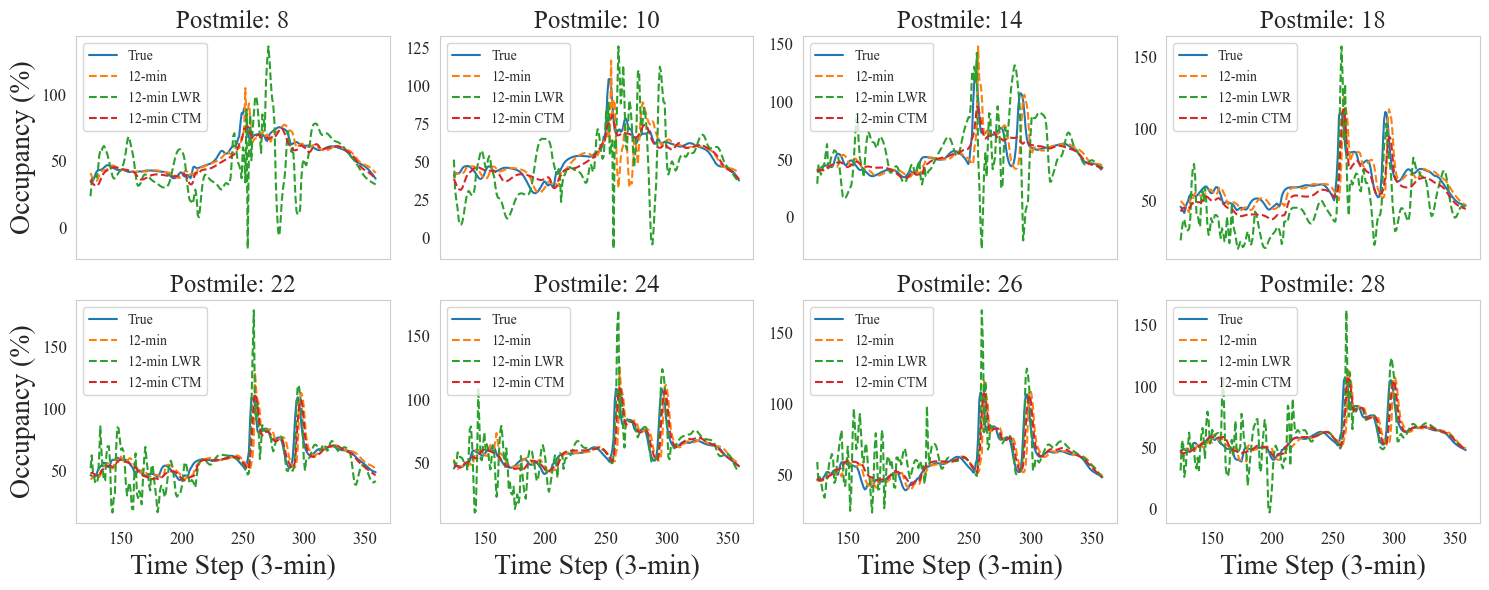

In [61]:
# plot 12-min traffic flow prediction
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 6), sharex=True)
axes = axes.flatten()
# select the postmiles (total 8) we need to include in the plot
select_postmile = [4, 5, 7, 9, 11, 12, 13, 14]

for i in range(8):
    col = select_postmile[i]
    axes[i].plot(pred_flow_recon.loc[col,:].iloc[4:], label='True')
    axes[i].plot(pred_flow_4.loc[col,:].iloc[:-4], linestyle = '--', label='12-min')
    axes[i].plot(pred_flow_4_LWR.loc[col,:].iloc[:-4], linestyle = '--', label='12-min LWR')
    axes[i].plot(pred_flow_4_CTM.loc[col,:].iloc[:-4], linestyle = '--', label='12-min CTM')
    axes[i].set_title(f'Postmile: {col * 2}', fontsize = 18)
    # axes[i].set_ylim(-0.6, 0.8)
    
    axes[i].tick_params(axis='both', which='major', labelsize=12)
    axes[i].legend()
    
    if i >= 4:  # Subplots 12 to 15 correspond to the last row (index starts from 0)
        axes[i].set_xlabel('Time Step (3-min)', fontsize=20)

    # Add y-axis labels only for the subplots in the first column
    if i % 4 == 0:  # Subplots 0, 4, 8, 12 correspond to the first column
        axes[i].set_ylabel('Occupancy (%)', fontsize=20)
    axes[i].grid(False)
    
plt.tight_layout()
plt.rcParams['font.family'] = 'Times New Roman'

In [62]:
rmse_flow_4_proposed = np.sqrt(np.nanmean((pred_flow_recon.iloc[:,4:].values - pred_flow_4.iloc[:,:-4].values) ** 2))
print(rmse_flow_4_proposed)

mape_flow_4_proposed = np.nanmean(np.abs((pred_flow_recon.iloc[:,4:].values - pred_flow_4.iloc[:,:-4].values) / pred_flow_recon.iloc[:,4:].values)) * 100
print(mape_flow_4_proposed)

8.875555
7.155954092741013


In [63]:
rmse_flow_4_LWR = np.sqrt(np.nanmean((pred_flow_recon.iloc[:,4:].values - pred_flow_4_LWR.iloc[:,:-4].values) ** 2))
print(rmse_flow_4_LWR)

mape_flow_4_LWR = np.nanmean(np.abs((pred_flow_recon.iloc[:,4:].values - pred_flow_4_LWR.iloc[:,:-4].values) / pred_flow_recon.iloc[:,4:].values)) * 100
print(mape_flow_4_LWR)

24.596745
27.90451943874359


In [64]:
rmse_flow_4_CTM = np.sqrt(np.nanmean((pred_flow_recon.iloc[4:,4:].values - pred_flow_4_CTM.iloc[:,:-4].values) ** 2))
print(rmse_flow_4_CTM)

mape_flow_4_CTM = np.nanmean(np.abs((pred_flow_recon.iloc[4:,4:].values - pred_flow_4_CTM.iloc[:,:-4].values) / pred_flow_recon.iloc[4:,4:].values)) * 100
print(mape_flow_4_CTM)

7.204781
7.118528336286545


### 15 mins prediction

In [65]:
k_x_4 = pred_k_x_4.transpose().stack().reset_index()
k_x_4 = torch.tensor(k_x_4.values)[:, 2].unsqueeze(1)

q_x_4 = pred_q_x_4.transpose().stack().reset_index()
q_x_4 = torch.tensor(q_x_4.values)[:, 2].unsqueeze(1)

v_x_4 = pred_v_x_4.transpose().stack().reset_index()
v_x_4 = torch.tensor(v_x_4.values)[:, 2].unsqueeze(1)

k_xx_4 = pred_k_xx_4.transpose().stack().reset_index()
k_xx_4 = torch.tensor(k_xx_4.values)[:, 2].unsqueeze(1)

q_xx_4 = pred_q_xx_4.transpose().stack().reset_index()
q_xx_4 = torch.tensor(q_xx_4.values)[:, 2].unsqueeze(1)

v_xx_4 = pred_v_xx_4.transpose().stack().reset_index()
v_xx_4 = torch.tensor(v_xx_4.values)[:, 2].unsqueeze(1)


In [66]:
q_x_4_LWR = pred_q_x_4_LWR.transpose().stack().reset_index()
q_x_4_LWR = torch.tensor(q_x_4_LWR.values)[:, 2].unsqueeze(1)

In [67]:
z_4 = torch.cat((occu_4, flow_4, speed_4, k_x_4, q_x_4, v_x_4), dim=1)
Theta_4 = build_collection_library(z_4, poly_order=params['poly_order'], include_sine=False,
                                   device=torch.device('cpu')).float()
k_t_predict_4 = torch.matmul(Theta_4, coeff)
occu_5 = occu_4 + k_t_predict_4
pred_occu_5 = torch.cat((X_occu_all, occu_5), dim=1).detach().numpy()
pred_occu_5 = pd.DataFrame(pred_occu_5, columns=['TimeStep', 'Station_Number', 'Occupancy'])
pred_occu_5['TimeStep'] = pred_occu_5['TimeStep'].astype(int)
pred_occu_5['Station_Number'] = pred_occu_5['Station_Number'].astype(int)
pred_occu_5 = pred_occu_5.pivot(index='Station_Number', columns='TimeStep', values='Occupancy')
# add step size to column index
pred_occu_5.columns = pred_occu_5.columns + 5

In [68]:
# prediction based on LWR Model
# The LWR model: dk/dt = -dq/dx, since we have k = 6*occu, thus d occu/dt = -(1/6)dq/dx
k_t_predict_4_LWR = -(1/6) * q_x_4_LWR
occu_5_LWR = occu_4_LWR + k_t_predict_4_LWR

pred_occu_5_LWR = torch.cat((X_occu_all, occu_5_LWR), dim=1).detach().numpy()
pred_occu_5_LWR = pd.DataFrame(pred_occu_5_LWR, columns = ['TimeStep','Station_Number','Occupancy'])
pred_occu_5_LWR['TimeStep'] = pred_occu_5_LWR['TimeStep'].astype(int)
pred_occu_5_LWR['Station_Number'] = pred_occu_5_LWR['Station_Number'].astype(int)
pred_occu_5_LWR = pred_occu_5_LWR.pivot(index='Station_Number', columns='TimeStep', values='Occupancy')
pred_occu_5_LWR.columns = pred_occu_5_LWR.columns + 5

In [69]:
pred_occu_5_CTM = pred_occu_4_CTM.iloc[1:,:].values + 1/12 * pred_flow_4_CTM.iloc[:-1,:].values - 1/12 * pred_flow_4_CTM.iloc[1:,:].values
pred_occu_5_CTM = pd.DataFrame(pred_occu_5_CTM, index=pred_occu_4_CTM.iloc[1:,:].index, columns=pred_occu_4_CTM.columns)
pred_occu_5_CTM.columns = pred_occu_5_CTM.columns + 1

In [70]:
# convert pred_occu_5 to long format and input into Flow Net and Speed Net
pred_occu_5_long = pred_occu_5.transpose().stack().reset_index()
pred_occu_5_long.columns = ['TimeStep', 'Station_Number', 'Occupancy']
# change pred_occu_5_long to torch.tensor type
pred_occu_5_long = torch.tensor(pred_occu_5_long.values)
# input pred_occu_5 into the FlowNet and SpeedNet
flow_5 = Network.FlowNet(pred_occu_5_long.float())
# change flow_5 and speed_5 into pandas long format
pred_flow_5_long = torch.cat((pred_occu_5_long.float()[:, :2], flow_1), dim=1)
pred_flow_5_long = pd.DataFrame(pred_flow_5_long.detach().numpy())
pred_flow_5_long.columns = ['TimeStep', 'Station_Number', 'Flow']
pred_flow_5_long['TimeStep'] = pred_flow_5_long['TimeStep'].astype(int)
pred_flow_5_long['Station_Number'] = pred_flow_5_long['Station_Number'].astype(int)
# convert these two to wide format
pred_flow_5 = pred_flow_5_long.pivot(index='Station_Number', columns='TimeStep', values='Flow')

In [71]:
# convet pred_occu_5_LWR to long format and input into Flow Net and Speed Net
pred_occu_5_LWR_long = pred_occu_5_LWR.transpose().stack().reset_index()
pred_occu_5_LWR_long.columns = ['TimeStep', 'Station_Number', 'Occupancy']
pred_occu_5_LWR_long = torch.tensor(pred_occu_5_LWR_long.values)
flow_5_LWR = Network.FlowNet(pred_occu_5_LWR_long.float())

# convet pred_occu_5_CTM to long format and input into Flow Net and Speed Net
pred_occu_5_CTM_long = pred_occu_5_CTM.transpose().stack().reset_index()
pred_occu_5_CTM_long.columns = ['TimeStep', 'Station_Number', 'Occupancy']
pred_occu_5_CTM_long = torch.tensor(pred_occu_5_CTM_long.values)
flow_5_CTM = Network.FlowNet(pred_occu_5_CTM_long.float())
# change flow_5_LWR into pandas long format
pred_flow_5_LWR_long = torch.cat((pred_occu_5_LWR_long.float()[:, :2], flow_5_LWR), dim=1)
pred_flow_5_LWR_long = pd.DataFrame(pred_flow_5_LWR_long.detach().numpy())
pred_flow_5_LWR_long.columns = ['TimeStep', 'Station_Number', 'Flow']
pred_flow_5_LWR_long['TimeStep'] = pred_flow_5_LWR_long['TimeStep'].astype(int)
pred_flow_5_LWR_long['Station_Number'] = pred_flow_5_LWR_long['Station_Number'].astype(int)

pred_flow_5_LWR = pred_flow_5_LWR_long.pivot(index='Station_Number', columns='TimeStep', values='Flow')
pred_q_x_5_LWR = pd.DataFrame(np.gradient(pred_flow_5_LWR.to_numpy(), axis=0), index=pred_flow_5_LWR.index,
                              columns=pred_flow_5_LWR.columns)

# change flow_5_CTM into pandas long format
pred_flow_5_CTM_long = torch.cat((pred_occu_5_CTM_long.float()[:, :2], flow_5_CTM), dim=1)
pred_flow_5_CTM_long = pd.DataFrame(pred_flow_5_CTM_long.detach().numpy())
pred_flow_5_CTM_long.columns = ['TimeStep', 'Station_Number', 'Flow']
pred_flow_5_CTM_long['TimeStep'] = pred_flow_5_CTM_long['TimeStep'].astype(int)
pred_flow_5_CTM_long['Station_Number'] = pred_flow_5_CTM_long['Station_Number'].astype(int)

pred_flow_5_CTM = pred_flow_5_CTM_long.pivot(index='Station_Number', columns='TimeStep', values='Flow')
pred_q_x_5_CTM = pd.DataFrame(np.gradient(pred_flow_5_CTM.to_numpy(), axis=0), index=pred_flow_5_CTM.index,
                              columns=pred_flow_5_CTM.columns)

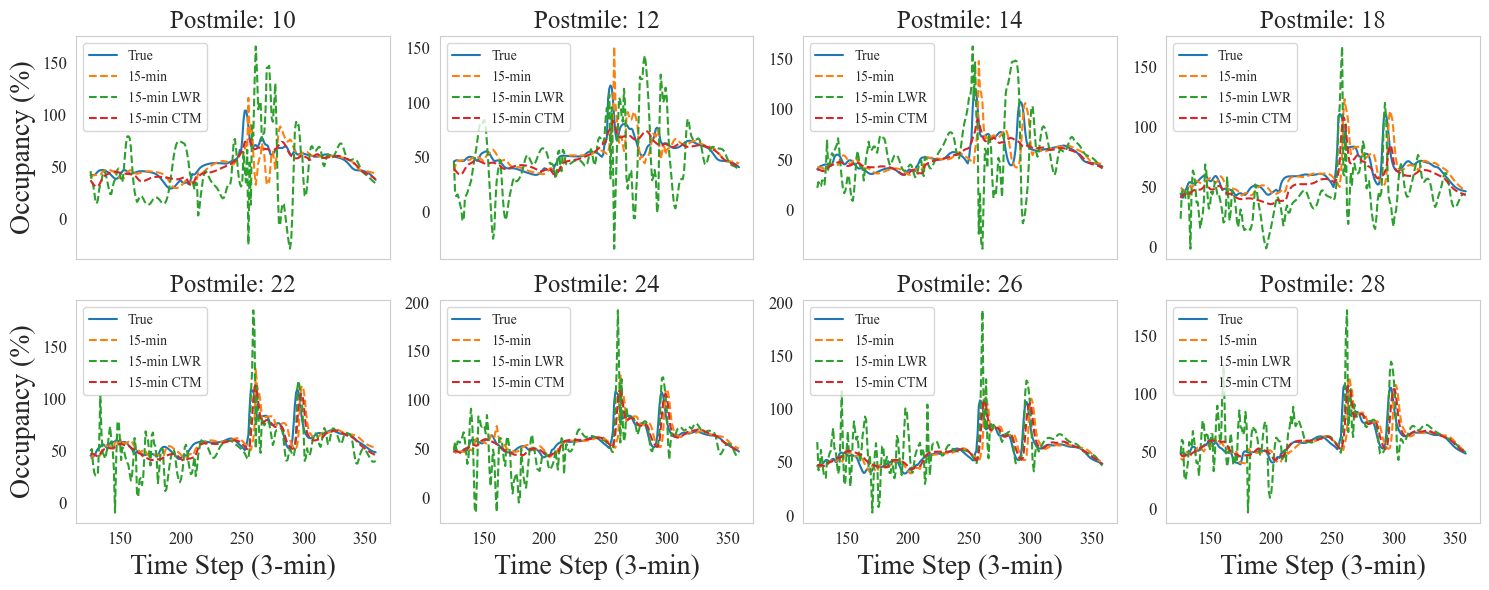

In [72]:
# plot 15-min traffic flow prediction
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 6), sharex=True)
axes = axes.flatten()
# select the postmiles (total 8) we need to include in the plot
select_postmile = [5, 6, 7, 9, 11, 12, 13, 14]

for i in range(8):
    col = select_postmile[i]
    axes[i].plot(pred_flow_recon.loc[col,:].iloc[5:], label='True')
    axes[i].plot(pred_flow_5.loc[col,:].iloc[:-5], linestyle = '--', label='15-min')
    axes[i].plot(pred_flow_5_LWR.loc[col,:].iloc[:-5], linestyle = '--', label='15-min LWR')
    axes[i].plot(pred_flow_5_CTM.loc[col,:].iloc[:-5], linestyle = '--', label='15-min CTM')
    axes[i].set_title(f'Postmile: {col * 2}', fontsize = 18)
    # axes[i].set_ylim(-0.6, 0.8)
    
    axes[i].tick_params(axis='both', which='major', labelsize=12)
    axes[i].legend()
    
    if i >= 4:  # Subplots 12 to 15 correspond to the last row (index starts from 0)
        axes[i].set_xlabel('Time Step (3-min)', fontsize=20)

    # Add y-axis labels only for the subplots in the first column
    if i % 4 == 0:  # Subplots 0, 4, 8, 12 correspond to the first column
        axes[i].set_ylabel('Occupancy (%)', fontsize=20)
    axes[i].grid(False)
    
plt.tight_layout()
plt.rcParams['font.family'] = 'Times New Roman'

In [73]:
rmse_flow_5_proposed = np.sqrt(np.nanmean((pred_flow_recon.iloc[:,5:].values - pred_flow_5.iloc[:,:-5].values) ** 2))
print(rmse_flow_5_proposed)

mape_flow_5_proposed = np.nanmean(np.abs((pred_flow_recon.iloc[:,5:].values - pred_flow_5.iloc[:,:-5].values) / pred_flow_recon.iloc[:,5:].values)) * 100
print(mape_flow_5_proposed)

10.36344
8.520984649658203


In [74]:
rmse_flow_5_LWR = np.sqrt(np.nanmean((pred_flow_recon.iloc[:,5:].values - pred_flow_5_LWR.iloc[:,:-5].values) ** 2))
print(rmse_flow_5_LWR)

mape_flow_5_LWR = np.nanmean(np.abs((pred_flow_recon.iloc[:,5:].values - pred_flow_5_LWR.iloc[:,:-5].values) / pred_flow_recon.iloc[:,5:].values)) * 100
print(mape_flow_5_LWR)

39.34241
41.71464145183563


In [75]:
rmse_flow_5_CTM = np.sqrt(np.nanmean((pred_flow_recon.iloc[5:,5:].values - pred_flow_5_CTM.iloc[:,:-5].values) ** 2))
print(rmse_flow_5_CTM)

mape_flow_5_CTM = np.nanmean(np.abs((pred_flow_recon.iloc[5:,5:].values - pred_flow_5_CTM.iloc[:,:-5].values) / pred_flow_recon.iloc[5:,5:].values)) * 100
print(mape_flow_5_CTM)

8.459129
8.227880299091339


In [76]:
# combine accuracy data into a dataframe
data = {
    'Prediction Length': ['RMSE(%)', 'MAPE(%)', 'RMSE(%)', 'MAPE(%)', 'RMSE(%)', 'MAPE(%)'],
    '3-min prediction': [rmse_flow_1_LWR, mape_flow_1_LWR, rmse_flow_1_CTM, mape_flow_1_CTM, rmse_flow_1_proposed, mape_flow_1_proposed],
    '6-min prediction': [rmse_flow_2_LWR, mape_flow_2_LWR, rmse_flow_2_CTM, mape_flow_2_CTM, rmse_flow_2_proposed, mape_flow_2_proposed],
    '9-min prediction': [rmse_flow_3_LWR, mape_flow_3_LWR, rmse_flow_3_CTM, mape_flow_3_CTM, rmse_flow_3_proposed, mape_flow_3_proposed],
    '12-min prediction': [rmse_flow_4_LWR, mape_flow_4_LWR, rmse_flow_4_CTM, mape_flow_4_CTM, rmse_flow_4_proposed, mape_flow_4_proposed],
    '15-min prediction': [rmse_flow_5_LWR, mape_flow_5_LWR, rmse_flow_5_CTM, mape_flow_5_CTM, rmse_flow_5_proposed, mape_flow_5_proposed]
}
df = pd.DataFrame(data)
df.iloc[:, 1:] = df.iloc[:, 1:].round(2)
df.to_csv('Tables/Prediction_Error_Proposed.csv', index=False)

### Combine Predictions Plots

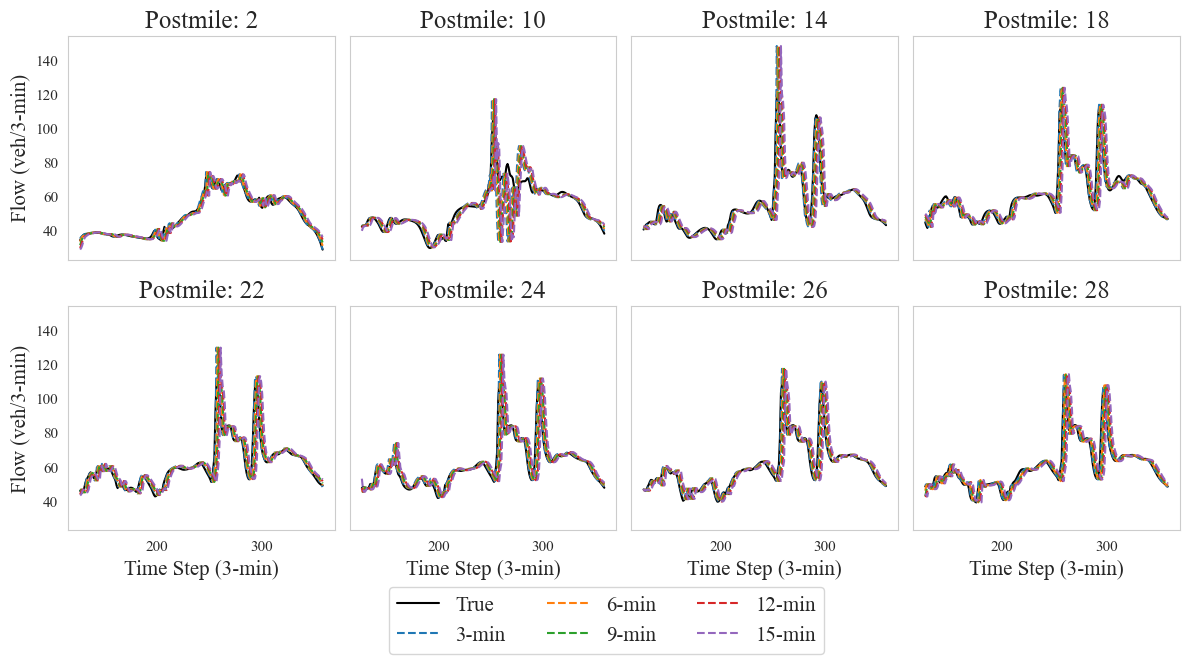

In [77]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12, 6), sharex=True, sharey=True)
axes = axes.flatten()

select_postmile = [1, 5, 7, 9, 11, 12, 13, 14]
# Plotting the data for each row in both dataframes
for i in range(8):
    col = select_postmile[i]
    axes[i].plot(pred_flow_recon.iloc[col, 5:], color = 'black', label='True')
    axes[i].plot(pred_flow_1.iloc[col, 4:-1], linestyle='--', label='3-min')
    axes[i].plot(pred_flow_2.iloc[col, 3:-2], linestyle='--', label='6-min')
    axes[i].plot(pred_flow_3.iloc[col, 2:-3], linestyle='--', label='9-min')
    axes[i].plot(pred_flow_4.iloc[col, 1:-4], linestyle='--', label='12-min')
    axes[i].plot(pred_flow_5.iloc[col, :-5], linestyle='--', label='15-min')
    axes[i].set_title(f'Postmile: {col * 2}', fontsize=18)
    axes[i].tick_params(axis='both', which='major', labelsize=11)
    # axes[i].legend(fontsize = 11)
    axes[i].grid(False)
    
axes[0].set_ylabel('Flow (veh/3-min)', fontsize=15)
axes[4].set_ylabel('Flow (veh/3-min)', fontsize=15)

for i in range(4,8):
    axes[i].set_xlabel('Time Step (3-min)', fontsize=15)
    

handles, labels = axes[0].get_legend_handles_labels()

lgd = fig.legend(handles, labels, bbox_to_anchor=(0.7,0.03), fontsize=15, ncol = 3)

plt.tight_layout()
plt.rcParams['font.family'] = 'Times New Roman'
fig.savefig("Figures_First_Order/predictions.png", dpi=300, bbox_inches='tight')

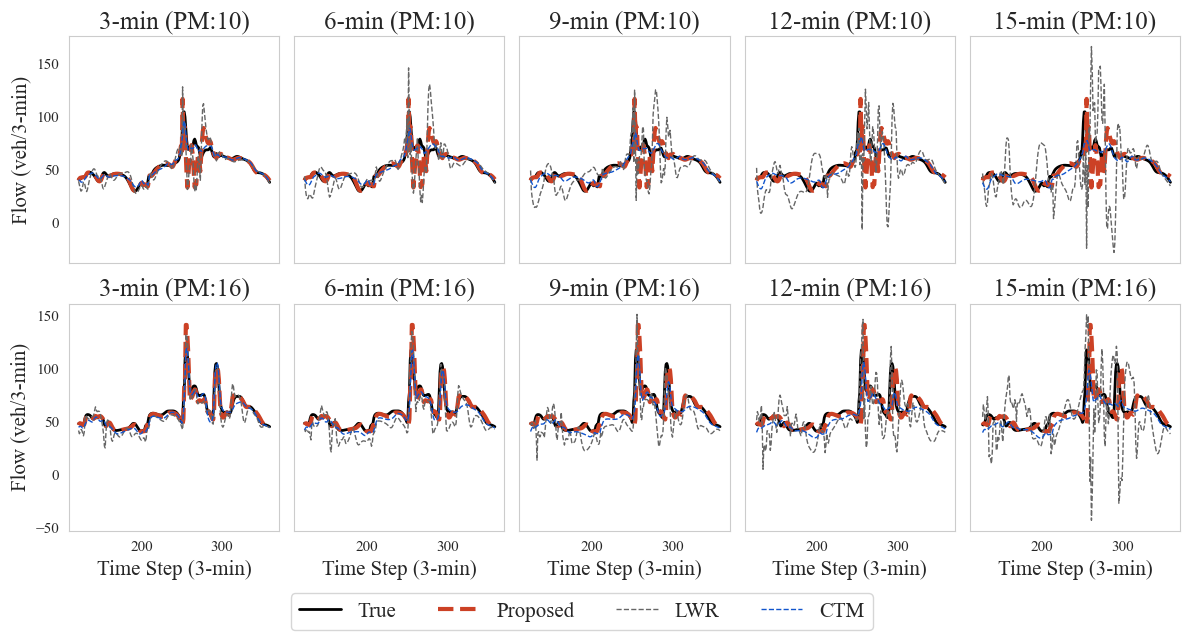

In [78]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(12, 6), sharex=True, sharey='row')
axes = axes.flatten()

color_true = '#000000'
color_proposed = '#cc4125'
color_LWR = '#666666'
color_CTM = '#1155cc'

axes[0].plot(pred_flow_recon.loc[5,:].iloc[1:], label='True', color = color_true, linewidth=2)
axes[0].plot(pred_flow_1.loc[5,:].iloc[:-1], linestyle = '--', label='Proposed', color=color_proposed, linewidth=3)
axes[0].plot(pred_flow_1_LWR.loc[5,:].iloc[:-1], linestyle = '--', label='LWR', color=color_LWR, linewidth=1)
axes[0].plot(pred_flow_1_CTM.loc[5,:].iloc[:-1], linestyle = '--', label='CTM', color=color_CTM, linewidth=1)
axes[0].set_title('3-min (PM:10)', fontsize = 18)
axes[0].tick_params(axis='both', which='major', labelsize=11)


axes[1].plot(pred_flow_recon.loc[5,:].iloc[2:], label='True', color = color_true, linewidth=2)
axes[1].plot(pred_flow_2.loc[5,:].iloc[:-2], linestyle = '--', label='Proposed', color=color_proposed, linewidth=3)
axes[1].plot(pred_flow_2_LWR.loc[5,:].iloc[:-2], linestyle = '--', label='LWR', color=color_LWR, linewidth=1)
axes[1].plot(pred_flow_2_CTM.loc[5,:].iloc[:-2], linestyle = '--', label='CTM', color=color_CTM, linewidth=1)
axes[1].set_title('6-min (PM:10)', fontsize = 18)
axes[1].tick_params(axis='both', which='major', labelsize=11)
# axes[1].legend()

axes[2].plot(pred_flow_recon.loc[5,:].iloc[3:], label='True', color = color_true, linewidth=2)
axes[2].plot(pred_flow_3.loc[5,:].iloc[:-3], linestyle = '--', label='Proposed', color=color_proposed, linewidth=3)
axes[2].plot(pred_flow_3_LWR.loc[5,:].iloc[:-3], linestyle = '--', label='LWR', color=color_LWR, linewidth=1)
axes[2].plot(pred_flow_3_CTM.loc[5,:].iloc[:-3], linestyle = '--', label='CTM', color=color_CTM, linewidth=1)
axes[2].set_title('9-min (PM:10)', fontsize = 18)
axes[2].tick_params(axis='both', which='major', labelsize=11)
# axes[2].legend()

axes[3].plot(pred_flow_recon.loc[5,:].iloc[4:], label='True', color = color_true, linewidth=2)
axes[3].plot(pred_flow_4.loc[5,:].iloc[:-4], linestyle = '--', label='Proposed', color=color_proposed, linewidth=3)
axes[3].plot(pred_flow_4_LWR.loc[5,:].iloc[:-4], linestyle = '--', label='LWR', color=color_LWR, linewidth=1)
axes[3].plot(pred_flow_4_CTM.loc[5,:].iloc[:-4], linestyle = '--', label='CTM', color=color_CTM, linewidth=1)
axes[3].set_title('12-min (PM:10)', fontsize = 18)
axes[3].tick_params(axis='both', which='major', labelsize=11)
# axes[3].legend()

axes[4].plot(pred_flow_recon.loc[5,:].iloc[5:], label='True', color = color_true, linewidth=2)
axes[4].plot(pred_flow_5.loc[5,:].iloc[:-5], linestyle = '--', label='Proposed', color=color_proposed, linewidth=3)
axes[4].plot(pred_flow_5_LWR.loc[5,:].iloc[:-5], linestyle = '--', label='LWR', color=color_LWR, linewidth=1)
axes[4].plot(pred_flow_5_CTM.loc[5,:].iloc[:-5], linestyle = '--', label='CTM', color=color_CTM, linewidth=1)
axes[4].set_title('15-min (PM:10)', fontsize = 18)
axes[4].tick_params(axis='both', which='major', labelsize=11)
# axes[4].legend()

axes[5].plot(pred_flow_recon.loc[8,:].iloc[1:], label='True', color = color_true, linewidth=2)
axes[5].plot(pred_flow_1.loc[8,:].iloc[:-1], linestyle = '--', label='Proposed', color=color_proposed, linewidth=3)
axes[5].plot(pred_flow_1_LWR.loc[8,:].iloc[:-1], linestyle = '--', label='LWR', color=color_LWR, linewidth=1)
axes[5].plot(pred_flow_1_CTM.loc[8,:].iloc[:-1], linestyle = '--', label='CTM', color=color_CTM, linewidth=1)
axes[5].set_title('3-min (PM:16)', fontsize = 18)
axes[5].tick_params(axis='both', which='major', labelsize=11)
# axes[5].legend()

axes[6].plot(pred_flow_recon.loc[8,:].iloc[2:], label='True', color = color_true, linewidth=2)
axes[6].plot(pred_flow_2.loc[8,:].iloc[:-2], linestyle = '--', label='Proposed', color=color_proposed, linewidth=3)
axes[6].plot(pred_flow_2_LWR.loc[8,:].iloc[:-2], linestyle = '--', label='LWR', color=color_LWR, linewidth=1)
axes[6].plot(pred_flow_2_CTM.loc[8,:].iloc[:-2], linestyle = '--', label='CTM', color=color_CTM, linewidth=1)
axes[6].set_title('6-min (PM:16)', fontsize = 18)
axes[6].tick_params(axis='both', which='major', labelsize=11)
# axes[6].legend()

axes[7].plot(pred_flow_recon.loc[8,:].iloc[3:], label='True', color = color_true, linewidth=2)
axes[7].plot(pred_flow_3.loc[8,:].iloc[:-3], linestyle = '--', label='Proposed', color=color_proposed, linewidth=3)
axes[7].plot(pred_flow_3_LWR.loc[8,:].iloc[:-3], linestyle = '--', label='LWR', color=color_LWR, linewidth=1)
axes[7].plot(pred_flow_3_CTM.loc[8,:].iloc[:-3], linestyle = '--', label='CTM', color=color_CTM, linewidth=1)
axes[7].set_title('9-min (PM:16)', fontsize = 18)
axes[7].tick_params(axis='both', which='major', labelsize=11)
# axes[7].legend()

axes[8].plot(pred_flow_recon.loc[8,:].iloc[4:], label='True', color = color_true, linewidth=2)
axes[8].plot(pred_flow_4.loc[8,:].iloc[:-4], linestyle = '--', label='Proposed', color=color_proposed, linewidth=3)
axes[8].plot(pred_flow_4_LWR.loc[8,:].iloc[:-4], linestyle = '--', label='LWR', color=color_LWR, linewidth=1)
axes[8].plot(pred_flow_4_CTM.loc[8,:].iloc[:-4], linestyle = '--', label='CTM', color=color_CTM, linewidth=1)
axes[8].set_title('12-min (PM:16)', fontsize = 18)
axes[8].tick_params(axis='both', which='major', labelsize=11)
# axes[8].legend()

axes[9].plot(pred_flow_recon.loc[8,:].iloc[5:], label='True', color = color_true, linewidth=2)
axes[9].plot(pred_flow_5.loc[8,:].iloc[:-5], linestyle = '--', label='Proposed', color=color_proposed, linewidth=3)
axes[9].plot(pred_flow_5_LWR.loc[8,:].iloc[:-5], linestyle = '--', label='LWR', color=color_LWR, linewidth=1)
axes[9].plot(pred_flow_5_CTM.loc[8,:].iloc[:-5], linestyle = '--', label='CTM', color=color_CTM, linewidth=1)
axes[9].set_title('15-min (PM:16)', fontsize = 18)  
axes[9].tick_params(axis='both', which='major', labelsize=11)
# axes[9].legend()

axes[0].set_ylabel('Flow (veh/3-min)', fontsize=15)
axes[5].set_ylabel('Flow (veh/3-min)', fontsize=15)

for i in range(5,10):
    axes[i].set_xlabel('Time Step (3-min)', fontsize=15)

handles, labels = axes[0].get_legend_handles_labels()

for i in range(0,10):
    axes[i].grid(False)

lgd = fig.legend(handles, labels, bbox_to_anchor=(0.74,0.02), fontsize=15, ncol = 4)

plt.tight_layout()
plt.rcParams['font.family'] = 'Times New Roman'
fig.savefig("Figures_First_Order/predictions_comparsion.png", dpi=300, bbox_inches='tight')